In [1]:
# Imports
import torch
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm 
from sklearn import metrics

from utils.dataGen import Patches
from utils.datasets import *
from ResNet.ResNet_2D_2 import ResNet_2D as CNN, ResidualBlock

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), torch.cuda.get_device_name()

(1, 'NVIDIA RTX A4000')

In [3]:
# Hyperparameters

in_channels = 55
classes = ["background", "leaf", "diseased"]
num_classes = len(classes)
weights = [1.0, 1.0, 1.0]
rgb_bands = [7, 15, 32]
# rgb_bands = [0]
img_size = 20
learning_rate = 1e-05
lr_step = 20
batch_size = 128
num_epochs = 50
frac = .7
save_dataset = True
augment = True
count = True
kfold = 1

In [4]:
# Initialize network

# model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
# model = ResNet(ResidualBlock, [2, 2, 2, 2], initial_inplanes = 55).to(device)
model = CNN(ResidualBlock).to(device)
print("Num of trainable param:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Num of trainable param: 194691


In [5]:
# Loss and optimizer

class_weights = torch.FloatTensor(weights).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=0.1)

In [6]:
# Init dataset

p_14 = Patches("D:\\gyeongsang_22_10_14\\PATCHES\\STACK_75_BANDS_14")
p_14_h = Patches("D:\\gyeongsang_22_10_14\\PATCHES\\STACK_75_BANDS_14_5")
p_21 = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES\\STACK_75_BANDS_21_1_2")
p_25_h = Patches("D:\\gyeongsang_22_10_25\\PATCHES\\STACK_75_BANDS_25_3")
p_25 = Patches("D:\\gyeongsang_22_10_25\\PATCHES\\STACK_75_BANDS_25")
p_28 = Patches("D:\\gyeongsang_22_10_28\\PATCHES\\STACK_75_BANDS_28")
p_28_h = Patches("D:\\gyeongsang_22_10_28\\PATCHES\\STACK_75_BANDS_28_healthy")

In [7]:
print(p_14.describe(),
      p_14_h.describe(),
      p_21.describe(),
      p_25_h.describe(),
      p_25.describe(),
      p_28.describe(),
      p_28_h.describe())

For hdr image, there are: 
 leaf          5160
background    4369
diseased       215
Name: class, dtype: int64 

For hdr image, there are: 
 leaf          1728
background     597
diseased       173
Name: class, dtype: int64 

For hdr image, there are: 
 background    575
leaf          338
diseased       61
Name: class, dtype: int64 

For hdr image, there are: 
 leaf    148
Name: class, dtype: int64 

For hdr image, there are: 
 leaf          663
background    650
diseased      117
Name: class, dtype: int64 

For hdr image, there are: 
 background    1148
leaf           710
diseased        96
Name: class, dtype: int64 

For hdr image, there are: 
 leaf    271
Name: class, dtype: int64 

None None None None None None None


In [8]:
# Get dataset

patch_14_hd = p_14_h.getDataset([40, 1725, 173])
patch_14_b  = p_14.getDataset([150, 0, 0])
patch_14    = [pd.concat([patch_14_hd[0], patch_14_b[0]]),
               pd.concat([patch_14_hd[1], patch_14_b[1]])]

patch_21    = p_21.getDataset([150, 0, 61])

patch_25 = p_25.getDataset([100, 0, 117])
# patch_25_h  = p_25_h.getDataset([0, 0, 0])
# patch_25    = [pd.concat([patch_25_bd[0], patch_25_h[0]]),
#                pd.concat([patch_25_bd[1], patch_25_h[1]])]

patch_28    = p_28.getDataset([100, 0, 96])

# Shuffle dataset

def shuffle(patch):
    return [patch[i].sample(frac=1) for i in range(len(patch))]

patch_14 = shuffle(patch_14)
patch_21 = shuffle(patch_21)
patch_25 = shuffle(patch_25)
patch_28 = shuffle(patch_28)

Training set has 1357 samples [0 1 2] class indices included
Validation set has 581 samples [0 1 2] class indices included
   Example: D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_14_5\hdr\background\88_267.HDR
   Unique: True


Training set has 105 samples [0] class indices included
Validation set has 45 samples [0] class indices included
   Example: D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_14\hdr\background\101_374.HDR
   Unique: True


Training set has 148 samples [0 2] class indices included
Validation set has 63 samples [0 2] class indices included
   Example: D:\gyeongsang_22_10_21_1\PATCHES\STACK_75_BANDS_21_1_2\hdr\background\81_282.HDR
   Unique: True


Training set has 152 samples [0 2] class indices included
Validation set has 65 samples [0 2] class indices included
   Example: D:\gyeongsang_22_10_25\PATCHES\STACK_75_BANDS_25\hdr\background\52_399.HDR
   Unique: True


Training set has 137 samples [0 2] class indices included
Validation set has 59 samples [0 2] class i

In [9]:
def splitDatasetKfold(patch, kfold, dtype='hdr', train_frac=0.7):   
    patch_kfold = []
    kfold_recs  = patch.copy()
    
    for k in range(kfold):
        tr = pd.DataFrame(columns=["path", "type", "class"])
        vl = tr.copy()
        for i in range(num_classes):
            tmp = patch.loc[(patch['class'] == i) & 
                             (patch['type'] == dtype)]
            tmp_tr = tmp.sample(frac=train_frac, replace=False, random_state=k)
            tmp_vl = tmp.drop(tmp_tr.index)

            tr = pd.concat([tr, tmp_tr])
            vl = pd.concat([vl, tmp_vl])
            
        kfold_recs.loc[tr.index, f'k{k}'] = 0
        kfold_recs.loc[vl.index, f'k{k}'] = 1
            
        patch_kfold.append([tr, vl])

    # print((kfold_recs.loc[:, [f'k{i}' for i in range(kfold)]].sum(axis=1) == 0).sum())
    
    return patch_kfold, kfold_recs

In [10]:
# patch_14_kfold, kfold_recs = splitDatasetKfold(patch_14, kfold)
# len(patch_14_kfold)

In [11]:
# Patch wrapper

img_14 = wrapPatch(patch_14)
img_21 = wrapPatch(patch_21)
img_25 = wrapPatch(patch_25)
img_28 = wrapPatch(patch_28)

patch_21_25_28 = pd.concat([patch_21[0], patch_25[0], patch_28[0]])
train_patch = pd.concat([patch_14[0], patch_21[0], patch_25[0], patch_28[0]])
val_patch = pd.concat([patch_14[1], patch_21[1], patch_25[1], patch_28[1]])

patch_21_25_28 = patch_21_25_28.sample(frac=1)
train_patch = train_patch.sample(frac=1)
val_patch = val_patch.sample(frac=1)

In [12]:
# Define training images

img_21_25_28 = wrapPatch(patch_21_25_28)
train_img = wrapPatch(train_patch)
val_img = wrapPatch(val_patch)

if count:
    countImg(train_img, classes)
    countImg(val_img, classes)

if save_dataset:
    train_img.img_df.to_csv("train.csv")
    val_img.img_df.to_csv("val.csv")

1899, with {'background': 378, 'leaf': 1208, 'diseased': 313}
813, with {'background': 162, 'leaf': 517, 'diseased': 134}


In [13]:
# Augment images 

if augment:
    train_img_aug1 = augmentPatch2(img_21_25_28, [0, 0, 3], ["Training set 21, 25 and 28"])
    train_img_aug2 = augmentPatch2(img_14[0], [0, 0, 3], ["Training set 14"])
    
    train_img = ConcatDataset([train_img] + train_img_aug1 + train_img_aug2)
    val_img = ConcatDataset([val_img])   
    
    if count:
        countImg(train_img, classes)
        countImg(val_img, classes)

Training set 21, 25 and 28
class index: 2
	 Rotated 90 deg
	 Rotated 180 deg
	 Rotated 270 deg
Training set 14
class index: 2
	 Rotated 90 deg
	 Rotated 180 deg
	 Rotated 270 deg
2838, with {'background': 378, 'leaf': 1208, 'diseased': 1252}
813, with {'background': 162, 'leaf': 517, 'diseased': 134}


In [14]:
# Load images

loaders = imagesLoader([[train_img, True ],
                        [val_img  , False],
                        [img_14[1], False],
                        [img_21[1], False],
                        [img_25[1], False],
                        [img_28[1], False]], batch_size)

train_loader = loaders[0]
test_loader = loaders[1]

next(iter(train_loader))[0].shape

torch.Size([128, 55, 20, 20])

In [15]:
# Check the images

# for train_sample in train_loader:
#    displayImgs(train_sample[0], train_sample[1], classes=classes, n=batch_size)
#    break

In [16]:
# Check the model

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        print(x_[0])
        break

tensor([ 0.5621,  0.2669, -0.0534], device='cuda:0')


In [17]:
# Evaluate the model

def evaluate(loader, model):
    actuals = np.array([])
    predictions = np.array([])
    evaluations = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)
            actuals = np.append(actuals, y.cpu().detach().numpy())
            predictions = np.append(predictions, model_pred.cpu().detach().numpy())
    
    for i in range(num_classes):
        ac = (actuals == i)
        pr = (predictions == i)

        ca = (ac & pr).sum() / ac.sum()
        evaluations = np.append(evaluations, ca)
        
    oa = (actuals == predictions).sum() / len(actuals)
    evaluations = np.append(evaluations, oa)
    
    model.train()

    return evaluations

print(evaluate(train_loader, model), evaluate(test_loader, model))

[0.         0.39403974 0.76517572 0.50528541] [0.         0.39458414 0.60447761 0.35055351]


In [18]:
def evaluateTorch(loader, model):
    actuals = []
    predictions = []
    evaluations = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)
            
            actuals.append(y)
            predictions.append(model_pred)
            
    actuals = torch.cat(actuals)
    predictions = torch.cat(predictions)
    
    for i in range(num_classes):
        ac = (actuals == i)
        pr = (predictions == i)

        ca = (ac & pr).sum() / ac.sum()
        evaluations.append(ca)

    oa = (actuals == predictions).sum() / len(actuals)
    evaluations.append(oa)
    
    model.train()

    return [e.item() for e in evaluations]

print(evaluateTorch(train_loader, model), evaluateTorch(test_loader, model))

[0.0, 0.39403972029685974, 0.7651757001876831, 0.505285382270813] [0.0, 0.39458414912223816, 0.60447758436203, 0.3505535125732422]


In [19]:
# Make a list to record training progress

eval_ent = [train_loader, test_loader, loaders[2]]
eval_hist = [[[] for i in range(2 + num_classes)]for i in range(len(eval_ent))]
eval_idx = 1
highest_acc = 0
highest_dis = 0

b_oa = 0
b_d = 0
trained_epochs = 0

In [20]:
# Train the network

for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())
    
    scheduler.step()
    eval_hist[0][0].append(np.average(batch_loss))
    print("loss: ", eval_hist[0][0][-1])
    
    for ee, eh in zip(eval_ent, eval_hist):
        ev = evaluateTorch(ee, model)
        for i in range(len(ev)):
            eh[i + 1].append(ev[i])
     
    c_acc = eval_hist[eval_idx][-1][-1]
    d_acc = eval_hist[eval_idx][2 + 1][-1]
    p_acc = highest_acc
    
    if (c_acc > highest_acc):
        print(f"Best OA is on {epoch} epoch") 
        torch.save(model.state_dict(), os.getcwd() + f"\\ResNet3D_노균병_OA{epoch}_best.pt")
        highest_acc = c_acc
        b_oa = epoch
        
    if (((abs(c_acc - p_acc) < 6) or (c_acc > p_acc)) and (d_acc > highest_dis)):
        print(f"Best diseased accuracy is on {epoch} epoch") 
        torch.save(model.state_dict(), os.getcwd() + f"\\ResNet3D_노균병_d{epoch}_best.pt")
        b_d = epoch
        if c_acc > 0.8:
            highest_dis = d_acc
    
    print(optimizer.param_groups[0]['lr'])   
    trained_epochs = epoch
    for i in range(num_classes + 1):
        print(f"accuracy_{i}: {eval_hist[0][i + 1][-1]}, {eval_hist[1][i + 1][-1]}, {eval_hist[2][i + 1][-1]}")
        # print(f"accuracy_{i}: {eval_hist[0][i + 1][-1]}")

Epoch[0/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:35<00:00,  1.54s/it]


loss:  1.0996641594430674
Best OA is on 0 epoch
1e-05
accuracy_0: 0.0, 0.0, 0.0
accuracy_1: 1.0, 1.0, 1.0
accuracy_2: 0.003993610385805368, 0.0, 0.0
accuracy_3: 0.4274136424064636, 0.6359163522720337, 0.8258785605430603


Epoch[1/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:32<00:00,  1.41s/it]


loss:  0.897142793821252
Best diseased accuracy is on 1 epoch
1e-05
accuracy_0: 0.0, 0.0, 0.0
accuracy_1: 0.8965231776237488, 0.9013539552688599, 0.9013539552688599
accuracy_2: 0.6038338541984558, 0.15671642124652863, 0.09615384787321091
accuracy_3: 0.6479915380477905, 0.5990159511566162, 0.7523961663246155


Epoch[2/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.39s/it]


loss:  0.7942019156787706
Best diseased accuracy is on 2 epoch
1e-05
accuracy_0: 0.005291005130857229, 0.006172839552164078, 0.0
accuracy_1: 0.8807947039604187, 0.8607349991798401, 0.8607349991798401
accuracy_2: 0.8027156591415405, 0.28358209133148193, 0.19230769574642181
accuracy_3: 0.729739248752594, 0.5953259468078613, 0.7268370389938354


Epoch[3/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.7018352332322494
Best OA is on 3 epoch
Best diseased accuracy is on 3 epoch
1e-05
accuracy_0: 0.27248677611351013, 0.25925925374031067, 0.28070175647735596
accuracy_1: 0.9238410592079163, 0.9187620878219604, 0.9187620878219604
accuracy_2: 0.7939296960830688, 0.2761194109916687, 0.17307692766189575
accuracy_3: 0.7797744274139404, 0.6814268231391907, 0.7987220287322998


Epoch[4/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:32<00:00,  1.40s/it]


loss:  0.6128918113915817
Best OA is on 4 epoch
Best diseased accuracy is on 4 epoch
1e-05
accuracy_0: 0.523809552192688, 0.5493826866149902, 0.6491228342056274
accuracy_1: 0.9461920261383057, 0.9323017597198486, 0.9323017597198486
accuracy_2: 0.8027156591415405, 0.2761194109916687, 0.1538461595773697
accuracy_3: 0.8266384601593018, 0.7478474378585815, 0.8418530225753784


Epoch[5/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.5569354852904445
Best OA is on 5 epoch
Best diseased accuracy is on 5 epoch
1e-05
accuracy_0: 0.658730149269104, 0.6913580298423767, 0.7719298005104065
accuracy_1: 0.9552980065345764, 0.9419729113578796, 0.9419729113578796
accuracy_2: 0.809904158115387, 0.2985074520111084, 0.1538461595773697
accuracy_3: 0.8516560792922974, 0.785977840423584, 0.8610223531723022


Epoch[6/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.5065755105536917
Best OA is on 6 epoch
Best diseased accuracy is on 6 epoch
1e-05
accuracy_0: 0.7592592835426331, 0.7839506268501282, 0.7719298005104065
accuracy_1: 0.9536423683166504, 0.9342359900474548, 0.9342359900474548
accuracy_2: 0.8266773223876953, 0.3731343150138855, 0.21153846383094788
accuracy_3: 0.8717406392097473, 0.8118081092834473, 0.859424889087677


Epoch[7/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.4581046285836593
Best OA is on 7 epoch
1e-05
accuracy_0: 0.7962962985038757, 0.8148148059844971, 0.7894737124443054
accuracy_1: 0.9701986908912659, 0.9477756023406982, 0.9477756023406982
accuracy_2: 0.8130990266799927, 0.31343284249305725, 0.1538461595773697
accuracy_3: 0.8777307868003845, 0.8167281746864319, 0.8674121499061584


Epoch[8/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.39s/it]


loss:  0.43330171963442926
Best OA is on 8 epoch
1e-05
accuracy_0: 0.8280423283576965, 0.8580247163772583, 0.859649121761322
accuracy_1: 0.9627483487129211, 0.9342359900474548, 0.9342359900474548
accuracy_2: 0.8250798583030701, 0.36567163467407227, 0.21153846383094788
accuracy_3: 0.8840732574462891, 0.8253382444381714, 0.8674121499061584


Epoch[9/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.40375206133593683
Best OA is on 9 epoch
1e-05
accuracy_0: 0.8439153432846069, 0.8703703880310059, 0.859649121761322
accuracy_1: 0.9726821184158325, 0.9419729113578796, 0.9419729113578796
accuracy_2: 0.8123003244400024, 0.3283582031726837, 0.1538461595773697
accuracy_3: 0.8847779631614685, 0.8265682458877563, 0.8690095543861389


Epoch[10/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.3846461604470792
Best OA is on 10 epoch
Best diseased accuracy is on 10 epoch
1e-05
accuracy_0: 0.8465608358383179, 0.8765432238578796, 0.859649121761322
accuracy_1: 0.9552980065345764, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8530351519584656, 0.44029849767684937, 0.23076923191547394
accuracy_3: 0.8957011699676514, 0.8376383781433105, 0.864217221736908


Epoch[11/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.3802209768606269
Best OA is on 11 epoch
Best diseased accuracy is on 11 epoch
1e-05
accuracy_0: 0.8650793433189392, 0.8827160596847534, 0.8771929740905762
accuracy_1: 0.9552980065345764, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.8522364497184753, 0.447761207818985, 0.23076923191547394
accuracy_3: 0.8978153467178345, 0.8388683795928955, 0.864217221736908


Epoch[12/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.3489550313223963
Best OA is on 12 epoch
1e-05
accuracy_0: 0.8650793433189392, 0.8827160596847534, 0.8771929740905762
accuracy_1: 0.9627483487129211, 0.9323017597198486, 0.9323017597198486
accuracy_2: 0.8434504866600037, 0.44029849767684937, 0.21153846383094788
accuracy_3: 0.8971105813980103, 0.8413283824920654, 0.8674121499061584


Epoch[13/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.33739276683848834
Best OA is on 13 epoch
1e-05
accuracy_0: 0.8862434029579163, 0.895061731338501, 0.8947368264198303
accuracy_1: 0.9627483487129211, 0.9381044507026672, 0.9381044507026672
accuracy_2: 0.8394568562507629, 0.43283581733703613, 0.19230769574642181
accuracy_3: 0.8981676697731018, 0.84624844789505, 0.8722044825553894


Epoch[14/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.3231040731720302
Best diseased accuracy is on 14 epoch
1e-05
accuracy_0: 0.8941798806190491, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9478476643562317, 0.9187620878219604, 0.9187620878219604
accuracy_2: 0.865015983581543, 0.46268656849861145, 0.23076923191547394
accuracy_3: 0.904157817363739, 0.8400983810424805, 0.859424889087677


Epoch[15/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.31836156871007837
Best OA is on 15 epoch
1e-05
accuracy_0: 0.8862434029579163, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9602649211883545, 0.9381044507026672, 0.9381044507026672
accuracy_2: 0.8506389856338501, 0.43283581733703613, 0.19230769574642181
accuracy_3: 0.9020436406135559, 0.847478449344635, 0.8722044825553894


Epoch[16/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.30325463025466254
Best OA is on 16 epoch
Best diseased accuracy is on 16 epoch
1e-05
accuracy_0: 0.89682537317276, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9495033025741577, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8690096139907837, 0.4776119291782379, 0.25
accuracy_3: 0.9069766998291016, 0.84870845079422, 0.8690095543861389


Epoch[17/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2944480673126552
1e-05
accuracy_0: 0.89682537317276, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9519867300987244, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8698083162307739, 0.4776119291782379, 0.25
accuracy_3: 0.9083861708641052, 0.84870845079422, 0.8690095543861389


Epoch[18/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.38s/it]


loss:  0.29553399008253345
Best OA is on 18 epoch
Best diseased accuracy is on 18 epoch
1e-05
accuracy_0: 0.9126983880996704, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.924564778804779, 0.924564778804779
accuracy_2: 0.8761980533599854, 0.49253731966018677, 0.25
accuracy_3: 0.9119097590446472, 0.8511685132980347, 0.8674121499061584


Epoch[19/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.27758097454257635
Best OA is on 19 epoch
Best diseased accuracy is on 19 epoch
1.0000000000000002e-06
accuracy_0: 0.9100528955459595, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.942052960395813, 0.914893627166748, 0.914893627166748
accuracy_2: 0.8857827186584473, 0.5447761416435242, 0.2884615361690521
accuracy_3: 0.9129668474197388, 0.8536285161972046, 0.8626198172569275


Epoch[20/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2801462904266689
Best OA is on 20 epoch
1.0000000000000002e-06
accuracy_0: 0.89682537317276, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9470198750495911, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8801916837692261, 0.5223880410194397, 0.2884615361690521
accuracy_3: 0.9108526706695557, 0.8560885190963745, 0.8722044825553894


Epoch[21/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.37s/it]


loss:  0.28237668910752173
1.0000000000000002e-06
accuracy_0: 0.8994709253311157, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9511589407920837, 0.9323017597198486, 0.9323017597198486
accuracy_2: 0.8761980533599854, 0.5, 0.25
accuracy_3: 0.9112050533294678, 0.8548585176467896, 0.8722044825553894


Epoch[22/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.28351228392642475
Best OA is on 22 epoch
1.0000000000000002e-06
accuracy_0: 0.9179894328117371, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9461920261383057, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.8809903860092163, 0.5223880410194397, 0.2884615361690521
accuracy_3: 0.9136715531349182, 0.8573185801506042, 0.8722044825553894


Epoch[23/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.35s/it]


loss:  0.27347792555456574
Best OA is on 23 epoch
1.0000000000000002e-06
accuracy_0: 0.9074074029922485, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9495033025741577, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8769968152046204, 0.5149253606796265, 0.26923078298568726
accuracy_3: 0.9119097590446472, 0.8585485816001892, 0.8738018870353699


Epoch[24/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2818073228649471
1.0000000000000002e-06
accuracy_0: 0.9021164178848267, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9528145790100098, 0.9323017597198486, 0.9323017597198486
accuracy_2: 0.8761980533599854, 0.5074626803398132, 0.25
accuracy_3: 0.9122621417045593, 0.8560885190963745, 0.8722044825553894


Epoch[25/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.35s/it]


loss:  0.27815273987210315
1.0000000000000002e-06
accuracy_0: 0.9126983880996704, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9503311514854431, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8777955174446106, 0.5223880410194397, 0.2884615361690521
accuracy_3: 0.9133192300796509, 0.8585485816001892, 0.8738018870353699


Epoch[26/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.28315851027550903
1.0000000000000002e-06
accuracy_0: 0.9153439402580261, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8777955174446106, 0.5149253606796265, 0.26923078298568726
accuracy_3: 0.9129668474197388, 0.8573185801506042, 0.8722044825553894


Epoch[27/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.27131881338098773
1.0000000000000002e-06
accuracy_0: 0.9153439402580261, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8777955174446106, 0.5149253606796265, 0.26923078298568726
accuracy_3: 0.9129668474197388, 0.8573185801506042, 0.8722044825553894


Epoch[28/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.35s/it]


loss:  0.2710401733284411
1.0000000000000002e-06
accuracy_0: 0.9047619104385376, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9503311514854431, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8777955174446106, 0.5223880410194397, 0.2884615361690521
accuracy_3: 0.9122621417045593, 0.8585485816001892, 0.8738018870353699


Epoch[29/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.35s/it]


loss:  0.2688072090563567
1.0000000000000002e-06
accuracy_0: 0.8994709253311157, 0.9074074029922485, 0.8947368264198303
accuracy_1: 0.9586092829704285, 0.9381044507026672, 0.9381044507026672
accuracy_2: 0.8698083162307739, 0.49253731966018677, 0.25
accuracy_3: 0.9115573763847351, 0.8585485816001892, 0.8769968152046204


Epoch[30/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2749473322992739
Best OA is on 30 epoch
1.0000000000000002e-06
accuracy_0: 0.920634925365448, 0.9197530746459961, 0.9298245906829834
accuracy_1: 0.9461920261383057, 0.924564778804779, 0.924564778804779
accuracy_2: 0.8801916837692261, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9136715531349182, 0.8597785830497742, 0.8722044825553894


Epoch[31/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2698049091774484
1.0000000000000002e-06
accuracy_0: 0.9100528955459595, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9511589407920837, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8753993511199951, 0.5149253606796265, 0.26923078298568726
accuracy_3: 0.9122621417045593, 0.8585485816001892, 0.8738018870353699


Epoch[32/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2719531584045161
1.0000000000000002e-06
accuracy_0: 0.89682537317276, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9528145790100098, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8769968152046204, 0.5149253606796265, 0.26923078298568726
accuracy_3: 0.9119097590446472, 0.8560885190963745, 0.8722044825553894


Epoch[33/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2719402190135873
1.0000000000000002e-06
accuracy_0: 0.9047619104385376, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9511589407920837, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8761980533599854, 0.5149253606796265, 0.26923078298568726
accuracy_3: 0.9119097590446472, 0.8585485816001892, 0.8738018870353699


Epoch[34/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.26530232248098956
1.0000000000000002e-06
accuracy_0: 0.9021164178848267, 0.9074074029922485, 0.9122806787490845
accuracy_1: 0.9495033025741577, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.8809903860092163, 0.5223880410194397, 0.2884615361690521
accuracy_3: 0.9129668474197388, 0.8560885190963745, 0.8722044825553894


Epoch[35/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2692182284334432
Best OA is on 35 epoch
1.0000000000000002e-06
accuracy_0: 0.9126983880996704, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8793929815292358, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9133192300796509, 0.8610085844993591, 0.8738018870353699


Epoch[36/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.27518419338309247
1.0000000000000002e-06
accuracy_0: 0.9153439402580261, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9495033025741577, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8761980533599854, 0.5074626803398132, 0.25
accuracy_3: 0.9126144647598267, 0.8560885190963745, 0.8706070184707642


Epoch[37/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.26751296870086505
Best diseased accuracy is on 37 epoch
1.0000000000000002e-06
accuracy_0: 0.9126983880996704, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9470198750495911, 0.924564778804779, 0.924564778804779
accuracy_2: 0.8841853141784668, 0.5522388219833374, 0.2884615361690521
accuracy_3: 0.9147286415100098, 0.8610085844993591, 0.8706070184707642


Epoch[38/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2638944782640623
1.0000000000000002e-06
accuracy_0: 0.9047619104385376, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9511589407920837, 0.9342359900474548, 0.9342359900474548
accuracy_2: 0.8753993511199951, 0.5074626803398132, 0.25
accuracy_3: 0.9115573763847351, 0.8597785830497742, 0.8753993511199951


Epoch[39/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2699316416097724
1.0000000000000002e-07
accuracy_0: 0.920634925365448, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9470198750495911, 0.9284332394599915, 0.9284332394599915
accuracy_2: 0.8793929815292358, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9136715531349182, 0.8610085844993591, 0.8738018870353699


Epoch[40/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.26256270641865936
Best OA is on 40 epoch
1.0000000000000002e-07
accuracy_0: 0.9074074029922485, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8801916837692261, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9129668474197388, 0.8622385859489441, 0.8753993511199951


Epoch[41/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2671995882106864
1.0000000000000002e-07
accuracy_0: 0.8941798806190491, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9536423683166504, 0.9342359900474548, 0.9342359900474548
accuracy_2: 0.8777955174446106, 0.5223880410194397, 0.2884615361690521
accuracy_3: 0.9122621417045593, 0.8597785830497742, 0.8769968152046204


Epoch[42/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2644019709981006
1.0000000000000002e-07
accuracy_0: 0.8862434029579163, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9569536447525024, 0.936170220375061, 0.936170220375061
accuracy_2: 0.8753993511199951, 0.5074626803398132, 0.26923078298568726
accuracy_3: 0.9115573763847351, 0.8585485816001892, 0.8769968152046204


Epoch[43/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2612708295169084
1.0000000000000002e-07
accuracy_0: 0.9074074029922485, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8793929815292358, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9126144647598267, 0.8622385859489441, 0.8753993511199951


Epoch[44/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.26091049028479535
1.0000000000000002e-07
accuracy_0: 0.9021164178848267, 0.9074074029922485, 0.9122806787490845
accuracy_1: 0.9495033025741577, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.8817891478538513, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9133192300796509, 0.8585485816001892, 0.8722044825553894


Epoch[45/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2664480189914289
1.0000000000000002e-07
accuracy_0: 0.9047619104385376, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8817891478538513, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9133192300796509, 0.8622385859489441, 0.8753993511199951


Epoch[46/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.2609441157268441
1.0000000000000002e-07
accuracy_0: 0.9021164178848267, 0.9074074029922485, 0.9122806787490845
accuracy_1: 0.9495033025741577, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.8801916837692261, 0.5298507213592529, 0.2884615361690521
accuracy_3: 0.9126144647598267, 0.8573185801506042, 0.8722044825553894


Epoch[47/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.27199946538261743
1.0000000000000002e-07
accuracy_0: 0.9047619104385376, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9486755132675171, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.8801916837692261, 0.5373134613037109, 0.2884615361690521
accuracy_3: 0.9126144647598267, 0.8622385859489441, 0.8753993511199951


Epoch[48/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.26386798529521277
1.0000000000000002e-07
accuracy_0: 0.920634925365448, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9461920261383057, 0.9226305484771729, 0.9226305484771729
accuracy_2: 0.8865814805030823, 0.5522388219833374, 0.2884615361690521
accuracy_3: 0.9164904356002808, 0.8597785830497742, 0.8690095543861389


Epoch[49/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.36s/it]


loss:  0.26527922114600305
1.0000000000000002e-07
accuracy_0: 0.9021164178848267, 0.9074074029922485, 0.9122806787490845
accuracy_1: 0.9511589407920837, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.8809903860092163, 0.5298507213592529, 0.2884615361690521
accuracy_3: 0.9136715531349182, 0.8573185801506042, 0.8722044825553894


In [21]:
import pickle

with open('training.pckl', 'wb') as f:
    pickle.dump(eval_hist, f)

Text(0.5, 1.0, 'Overal accuracy')

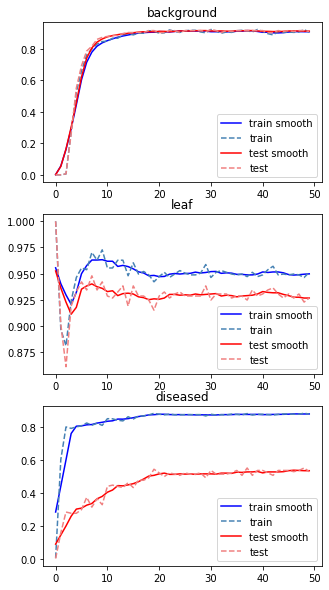

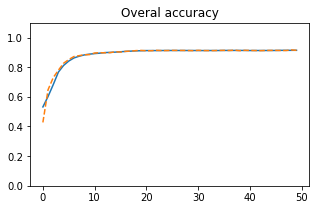

In [22]:
# Draw training graph

def smooth(y, box_pts=5):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

eval_hist_s = []

for data in eval_hist:
    data_c = copy.deepcopy(data)
    for i in range(len(data_c)):
        if len(data_c[i]) > 0: 
            data_c[i] = smooth(data_c[i])
        
    eval_hist_s.append(data_c)

epochs = [e for e in range(trained_epochs + 1)]

plt.figure(figsize=(5, 10))
for i in range(num_classes):
    ax = plt.subplot(311 + i)
    ax.set_title(classes[i])
    ax.plot(epochs, eval_hist_s[0][1 + i], 'blue', label='train smooth')
    ax.plot(epochs, eval_hist[0][1 + i], 'steelblue', linestyle='dashed', label='train')
    
    ax.plot(epochs, eval_hist_s[1][1 + i], 'red', label='test smooth')
    ax.plot(epochs, eval_hist[1][1 + i], 'lightcoral', linestyle='dashed', label='test')
    
    ax.legend(loc='lower right')

    
plt.figure(figsize=(5, 3))    
plt.plot(epochs, eval_hist_s[0][4], label='loss smothed')
plt.plot(epochs, eval_hist[0][4], linestyle='dashed', label='loss')   
plt.ylim(0, 1.1)
plt.title("Overal accuracy")

In [23]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2"])
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')

In [24]:
# Predict 

def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    
    return actual, prediction

In [25]:
# save last
# torch.save(model.state_dict(), os.getcwd() + "\\ResNet3D_노균병_last_ep.pt")

# Load weights
model.load_state_dict(torch.load(os.getcwd() + f"\\ResNet3D_노균병_d{b_d}_best.pt"))
# model.load_state_dict(torch.load(os.getcwd() + f"\\ResNet3D_노균병_OA{b_oa}_best.pt"))

<All keys matched successfully>

In [26]:
predictions = []
for dataset in loaders:
    predictions.append(predictDataset(dataset, model))

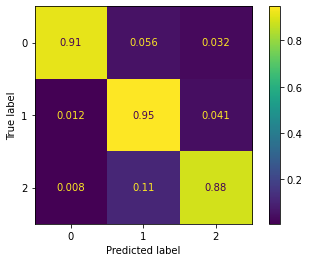

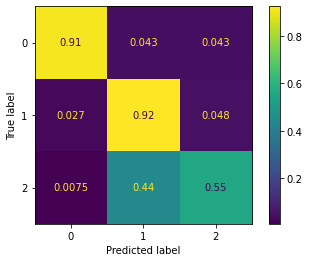

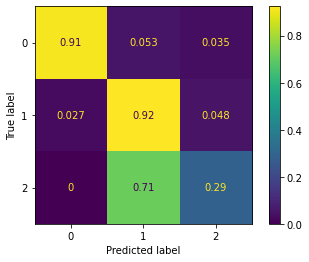

C:\Users\darlab\AppData\Local\Temp\ipykernel_7432\4226455957.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


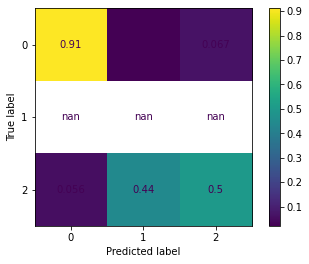

C:\Users\darlab\AppData\Local\Temp\ipykernel_7432\4226455957.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


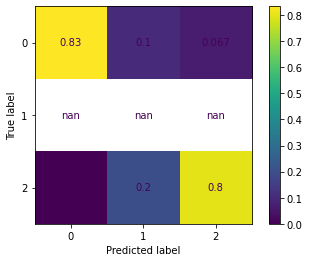

C:\Users\darlab\AppData\Local\Temp\ipykernel_7432\4226455957.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


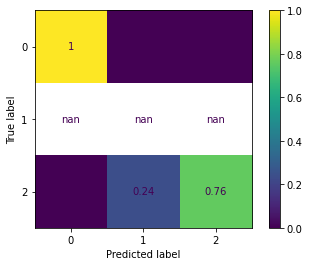

In [27]:
for actual, prediction in predictions:
    drawConfusionMatrix(actual, prediction, normalize=True)

In [28]:
model.load_state_dict(torch.load(os.getcwd() + f"\\ResNet3D_노균병_OA{b_oa}_best.pt"))

<All keys matched successfully>

In [29]:
predictions = []
for dataset in loaders:
    predictions.append(predictDataset(dataset, model))

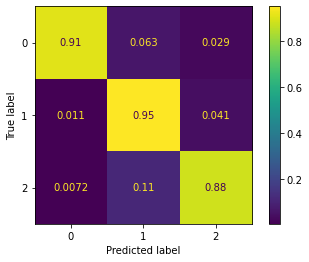

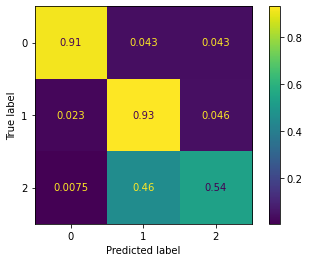

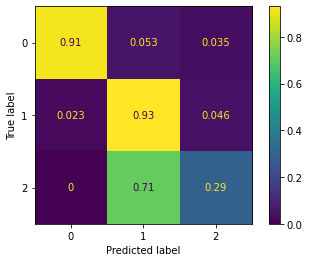

C:\Users\darlab\AppData\Local\Temp\ipykernel_7432\4226455957.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


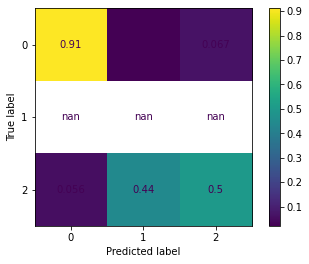

C:\Users\darlab\AppData\Local\Temp\ipykernel_7432\4226455957.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


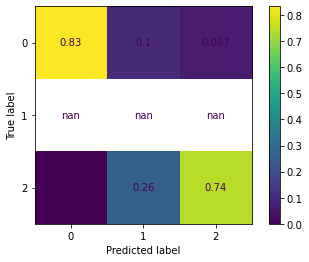

C:\Users\darlab\AppData\Local\Temp\ipykernel_7432\4226455957.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


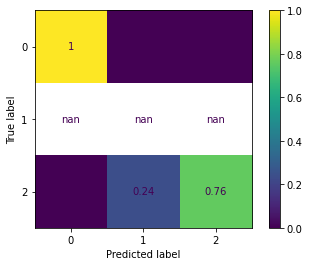

In [30]:
for actual, prediction in predictions:
    drawConfusionMatrix(actual, prediction, normalize=True)

In [31]:
b_d, b_oa

(37, 40)